Technohack virtual internship : Task1 
<hr/>

Dataset: https://www.kaggle.com/datasets/selfishgene/historical-hourly-weather-data

<br/>
Task Details : Analyze weather data Use a dataset of weather data and build a model that can predict future weather patterns

Step 1 : Importing all the required modules

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
import statsmodels.api as sm
from statsmodels.tsa.vector_ar.var_model import VAR
from sklearn.metrics import mean_squared_error, mean_absolute_error
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.stattools import acf

Step 2 : Importing the dataset

In [2]:
city_attributes = pd.read_csv("./Dataset/city_attributes.csv")
humidity = pd.read_csv("./Dataset/humidity.csv")
pressure = pd.read_csv("./Dataset/pressure.csv")
temprature = pd.read_csv("./Dataset/temperature.csv")

Since the data on individual city is seperated in different csv files we will combine them to form a dataframe for given city. For this model i have used Seattle

In [3]:
def cityDataframe(cityname):
    city_info = city_attributes[city_attributes['City'] == cityname]
    latitude = city_info['Latitude'].values[0]
    longitude = city_info['Longitude'].values[0]
    humidity_filter = humidity[['datetime', cityname]].rename(columns={cityname: 'humidity'})
    pressure_filter = pressure[['datetime', cityname]].rename(columns={cityname: 'pressure'})
    temprature_filter = temprature[['datetime', cityname]].rename(columns={cityname: 'temperature'})
    
    out = humidity_filter.merge(pressure_filter, on='datetime')
    out = out.merge(temprature_filter, on='datetime')
    
    return out, latitude, longitude

Seattledf = cityDataframe('Seattle')[0]
Seattledf.head()

,datetime,humidity,pressure,temperature
0,2012-10-01 12:00:00,NaN,NaN,NaN
1,2012-10-01 13:00:00,81.0,1027.0,281.800000
2,2012-10-01 14:00:00,80.0,1027.0,281.797217
3,2012-10-01 15:00:00,80.0,1028.0,281.789833
4,2012-10-01 16:00:00,79.0,1028.0,281.782449


Data Description

In [4]:
Seattledf.describe()

,humidity,pressure,temperature
count,44964.000000,45240.000000,45250.000000
mean,77.159038,1021.001216,284.409626
std,18.147464,9.737187,6.547986
min,13.000000,980.000000,263.780000
25%,66.000000,1015.000000,279.830000
50%,81.000000,1020.000000,283.940000
75%,93.000000,1027.000000,288.530000
max,100.000000,1058.000000,307.300000


Visualing the data in scatterplot to understand patterns and check various requirements for our model such as stationarity

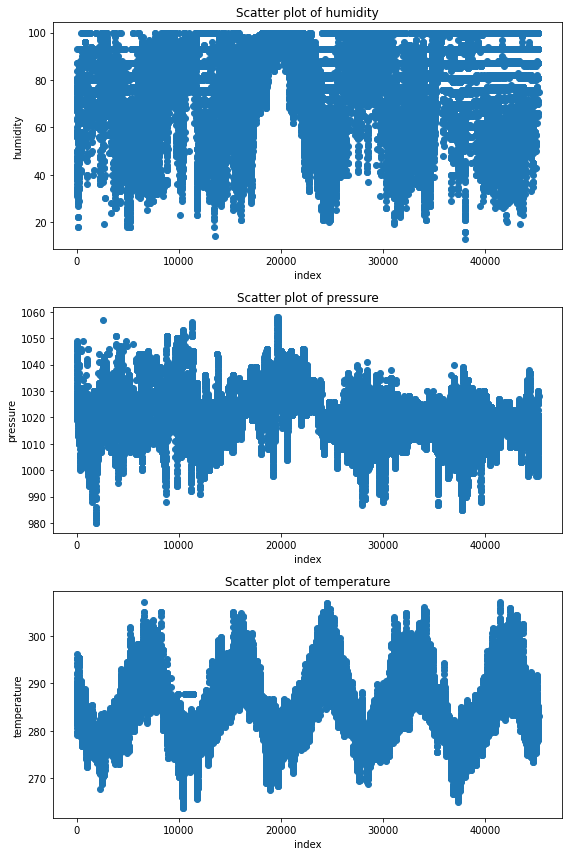

In [5]:
columns = ['humidity', 'pressure', 'temperature']

fig, axs = plt.subplots(len(columns), 1, figsize=(8, len(columns)*4))

for i, column in enumerate(columns):
    axs[i].scatter(list(range(len(Seattledf[column]))), Seattledf[column])
    axs[i].set_xlabel('index')
    axs[i].set_ylabel(column)
    axs[i].set_title('Scatter plot of ' + column)

plt.tight_layout()

plt.show()

Step 3 : Preprocessing Data


Interpolation : Interpolation is a technique used to estimate or predict values within a set of known data points. It is particularly useful when dealing with missing or incomplete data, or when you need to fill in gaps between data points.

In [6]:
Seattledf = Seattledf.interpolate()
Seattledf.head()

,datetime,humidity,pressure,temperature
0,2012-10-01 12:00:00,NaN,NaN,NaN
1,2012-10-01 13:00:00,81.0,1027.0,281.800000
2,2012-10-01 14:00:00,80.0,1027.0,281.797217
3,2012-10-01 15:00:00,80.0,1028.0,281.789833
4,2012-10-01 16:00:00,79.0,1028.0,281.782449


removing the rest of nan values from dataset

In [7]:
Seattledf = Seattledf.dropna()

In [8]:
print(Seattledf.isna().sum())
print(Seattledf.shape)

datetime       0
humidity       0
pressure       0
temperature    0
dtype: int64
(45252, 4)


Checking for outliers in dataset using boxplot

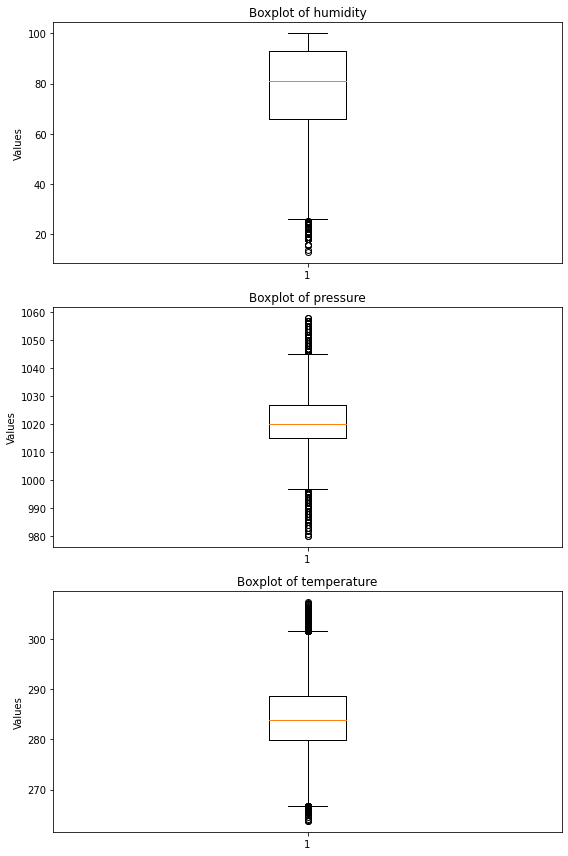

In [9]:
columns = ['humidity', 'pressure', 'temperature']

fig, axs = plt.subplots(len(columns), 1, figsize=(8, len(columns)*4))

for i, column in enumerate(columns):
    axs[i].boxplot(Seattledf[column])
    axs[i].set_ylabel('Values')
    axs[i].set_title('Boxplot of ' + column)

plt.tight_layout()

plt.show()

In [10]:
Seattledf.drop('datetime',axis=1,inplace=True)

From the boxplots we can see that ether are outlier in our dataset so we will use z-score normalization to detect those outliers and remove them

In [11]:
z_scores = np.abs((Seattledf - Seattledf.mean()) / Seattledf.std())

threshold = 2

outliers_mask = z_scores > threshold

Seattledf_cleaned = Seattledf.mask(outliers_mask)

Seattledf_cleaned = Seattledf_cleaned.dropna()

Seattledf_cleaned.shape


(39804, 3)

finally checking the results of z-score normalization

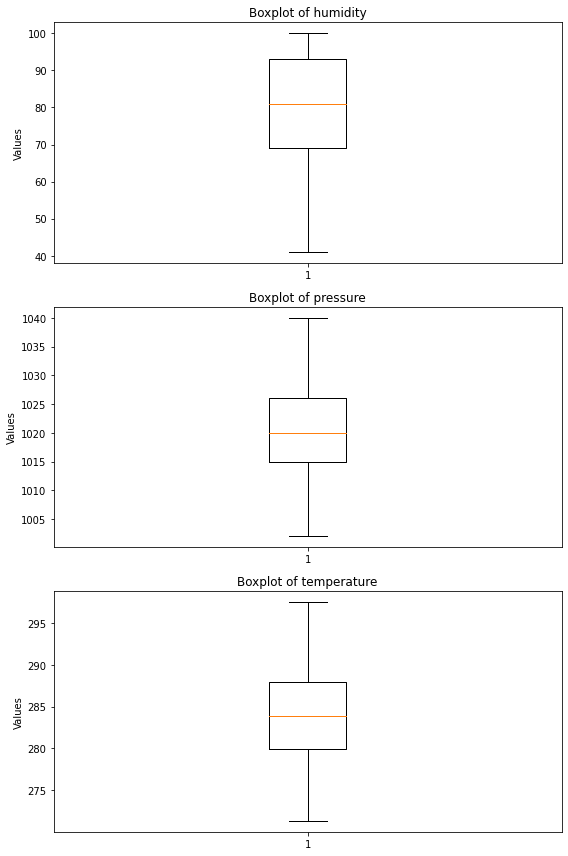

In [12]:
columns = ['humidity', 'pressure', 'temperature']

fig, axs = plt.subplots(len(columns), 1, figsize=(8, len(columns)*4))

for i, column in enumerate(columns):
    axs[i].boxplot(Seattledf_cleaned[column])
    axs[i].set_ylabel('Values')
    axs[i].set_title('Boxplot of ' + column)

plt.tight_layout()

plt.show()

checking correlations between each variables as it could be helpfull for VAR model

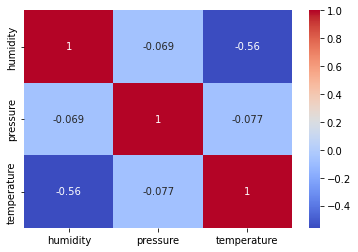

             humidity  pressure  temperature
humidity     1.000000 -0.068692    -0.559347
pressure    -0.068692  1.000000    -0.077444
temperature -0.559347 -0.077444     1.000000


In [13]:
numeric_columns = Seattledf.select_dtypes(include='number')
correlationmat = numeric_columns.corr()
sns.heatmap(correlationmat,annot=True,cmap='coolwarm')
plt.show()
print(correlationmat)

Step 4 : Building the models

Plotting the data again after preprocessing 

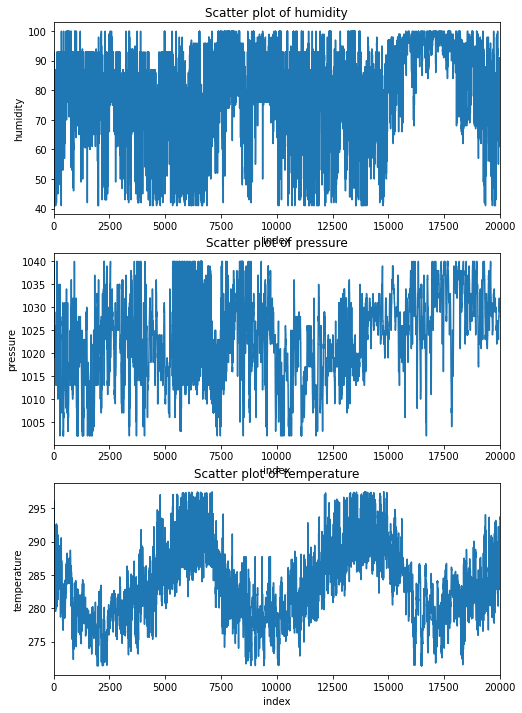

In [14]:
columns = ['humidity', 'pressure', 'temperature']

fig, axs = plt.subplots(len(columns), 1, figsize=(8, len(columns)*4))

for i, column in enumerate(columns):
    axs[i].plot(list(range(len(Seattledf_cleaned[column]))), Seattledf_cleaned[column])
    axs[i].set_xlabel('index')
    axs[i].set_ylabel(column)
    axs[i].set_title('Scatter plot of ' + column)
    axs[i].set_xlim(0,20000)

plt.show()

Autocorrelation (ACF) and lag plots are visual tools used in time series analysis to understand the correlation and patterns in the data over different time lags.

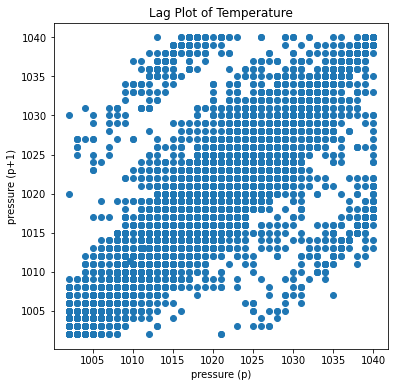

In [15]:
plt.figure(figsize=(6, 6))
pd.plotting.lag_plot(Seattledf_cleaned['pressure'])
plt.xlabel('pressure (p)')
plt.ylabel('pressure (p+1)')
plt.title('Lag Plot of Temperature')
plt.show()

Train test split

In [16]:
train_data, test_data = train_test_split(Seattledf_cleaned, test_size=0.2, shuffle=False)


VAR Model (Vector Auto Regression)

In [17]:
# Train the VAR model
model = VAR(train_data)
model_fit = model.fit()

# Make predictions on the test set
lag_order = model_fit.k_ar
predictions = model_fit.forecast(train_data.values[-lag_order:], steps=len(test_data))

# Calculate the root mean squared error (RMSE)
rmse = np.sqrt(mean_squared_error(test_data, predictions))
mae = mean_absolute_error(test_data, predictions)

# Print the RMSE
print('RMSE:', rmse)
print('MAE:', mae)


RMSE: 10.984173118914102
MAE: 8.375803441890179


c:\Users\resha\AppData\Local\Programs\Python\Python310\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


ACF plots to understand correlation of a variable with itself

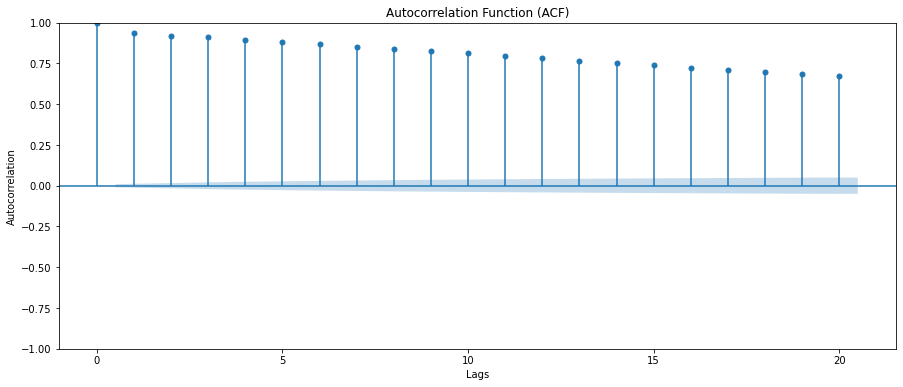

c:\Users\resha\AppData\Local\Programs\Python\Python310\lib\site-packages\statsmodels\graphics\tsaplots.py:348: FutureWarning: The default method 'yw' can produce PACF values outside of the [-1,1] interval. After 0.13, the default will change tounadjusted Yule-Walker ('ywm'). You can use this method now by setting method='ywm'.
  warnings.warn(


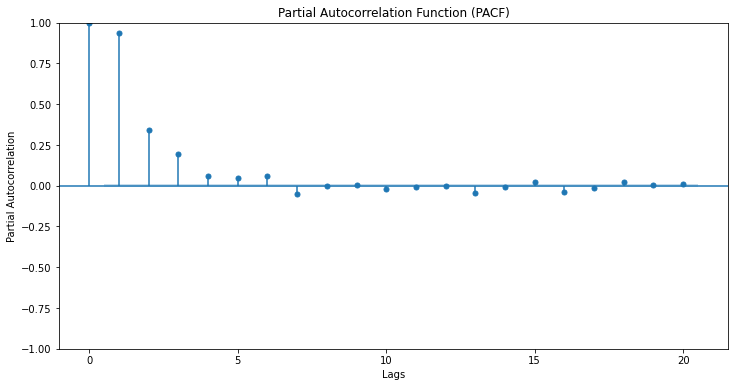

In [18]:
fig, ax = plt.subplots(figsize=(15, 6))
plot_acf(Seattledf_cleaned['pressure'], lags=20, ax=ax)
plt.xlabel('Lags')
plt.ylabel('Autocorrelation')
plt.title('Autocorrelation Function (ACF)')
plt.show()

# Plot PACF
fig, ax = plt.subplots(figsize=(12, 6))
plot_pacf(Seattledf_cleaned['pressure'], lags=20, ax=ax)
plt.xlabel('Lags')
plt.ylabel('Partial Autocorrelation')
plt.title('Partial Autocorrelation Function (PACF)')
plt.show()

ARIMA model (AutoRegressive Integrated Moving Average)

In [19]:
train_data_univariate = train_data['pressure']

model = ARIMA(train_data_univariate, order=(20, 1, 3)) 

model_fit = model.fit()

predictions = model_fit.predict(start=len(train_data_univariate), end=len(train_data_univariate) + len(test_data) - 1)

c:\Users\resha\AppData\Local\Programs\Python\Python310\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
c:\Users\resha\AppData\Local\Programs\Python\Python310\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
c:\Users\resha\AppData\Local\Programs\Python\Python310\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


c:\Users\resha\AppData\Local\Programs\Python\Python310\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
c:\Users\resha\AppData\Local\Programs\Python\Python310\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
c:\Users\resha\AppData\Local\Programs\Python\Python310\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
c:\Users\resha\AppData\Local\Programs\Python\Python310\lib\site-packages\statsmodels\tsa\base\tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an 

In [20]:
rmse = np.sqrt(mean_squared_error(test_data['pressure'], predictions))
mae = mean_absolute_error(test_data['pressure'], predictions)

print('RMSE:', rmse)
print('MAE:', mae)

RMSE: 7.053387730693745
MAE: 5.520973427307827
